In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft

In [30]:
sub_dirs = ['8hz_20trials/','9hz_20trials/','10hz_20trials/',
            '11hz_10trials_run1/','11hz_10trials_run2/',
            '12hz_10trials_run1/','12hz_10trials_run2/',
            '12.6hz_10trials_run1/','12.6hz_10trials_run2/',
            '13hz_10trials_run1/','13hz_10trials_run2/',
            '14hz_10trials_run1/','14hz_10trials_run2/',
            '15hz_10trials_run1/','15hz_10trials_run2/']

def load_data_temp_function(eeg, meta, classes):
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

### PSD Plots

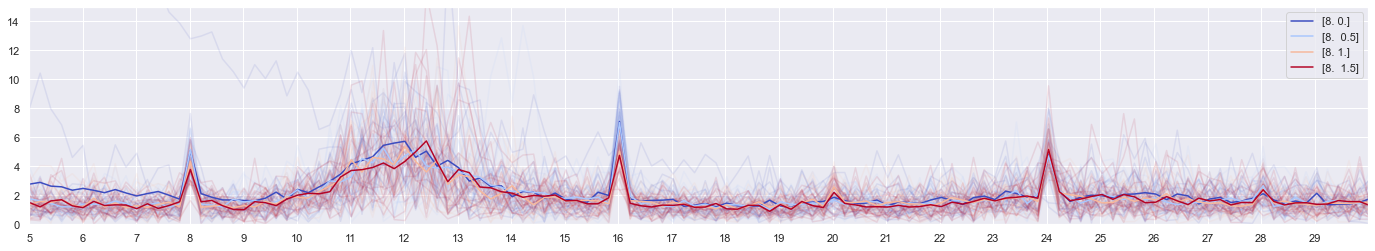

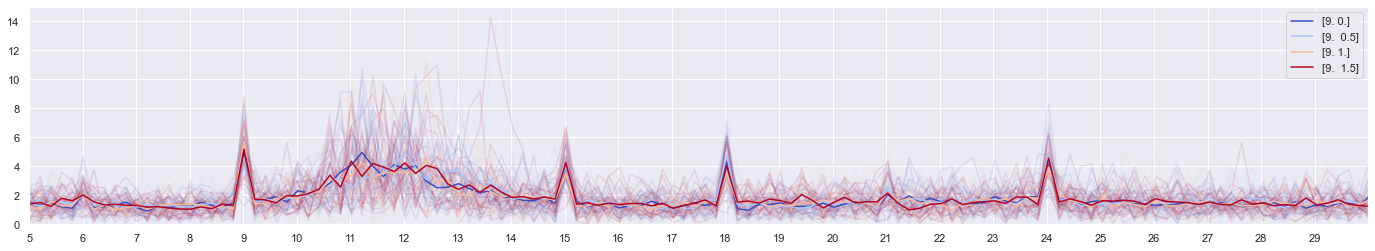

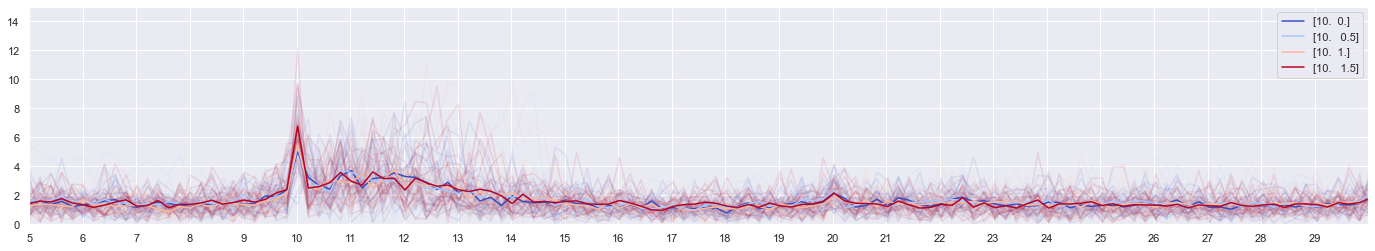

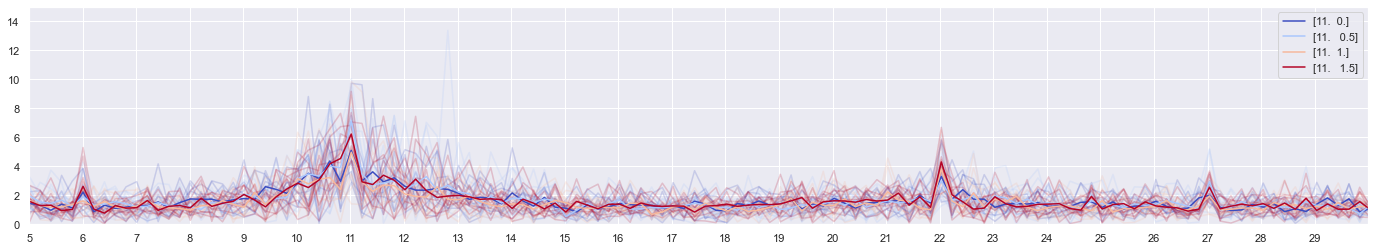

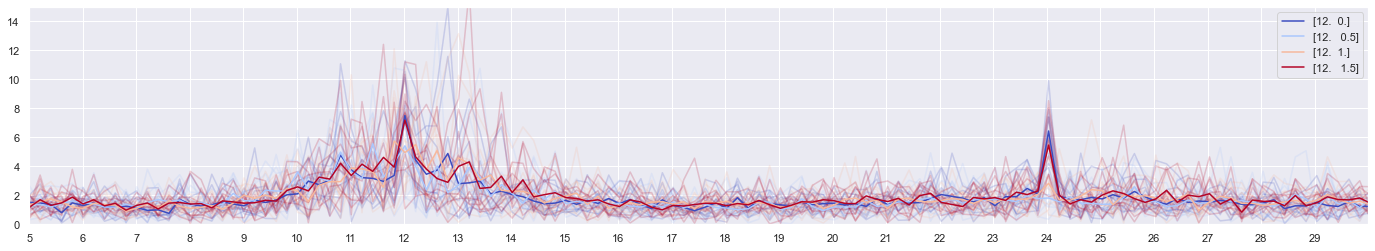

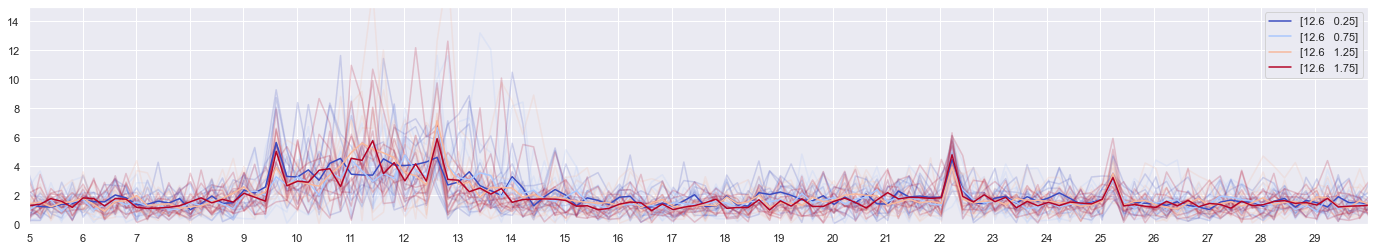

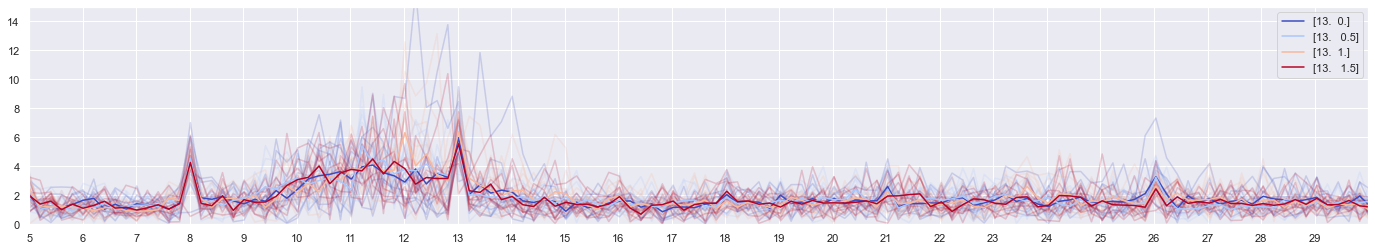

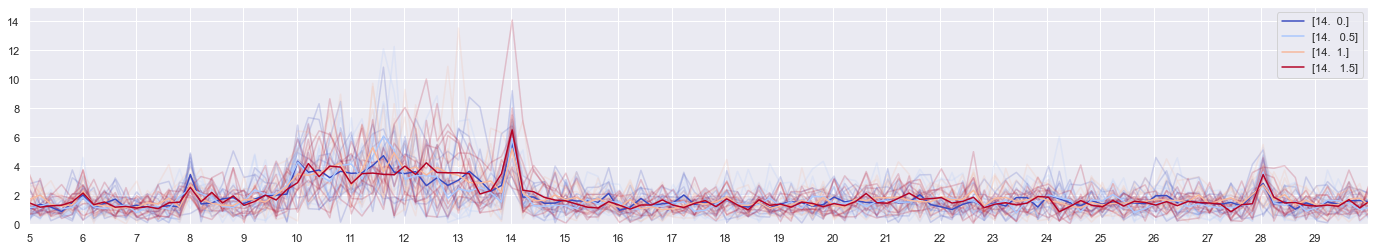

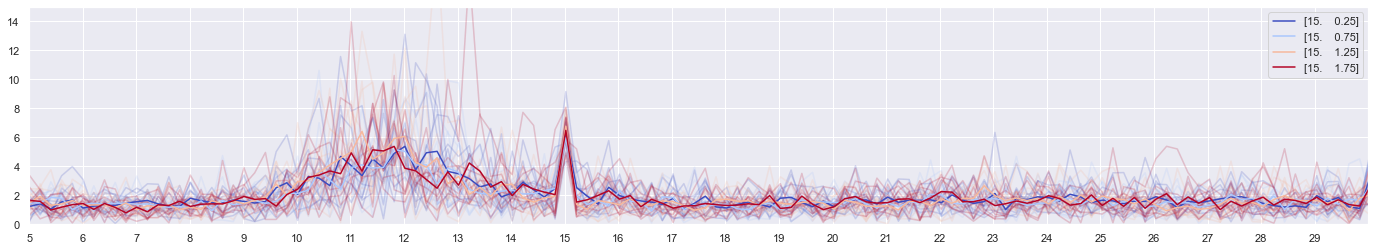

In [31]:
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    freqs = np.linspace(0.0, 300 / 2, 750)
    psd = 2/750*np.abs(fft(eeg)[:,:,:,:750])
    plt.figure(figsize=(24, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    ax.set_ylim(0, 15)
    colors=cm.coolwarm(np.linspace(0,1,len(classes)))
    for i,c in enumerate(colors):
        for j in range(eeg.shape[0]):
            sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color=c, alpha = 0.1)
    for i,c in enumerate(colors):
        sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(classes[i]),color=c)
    plt.xticks(range(5,30));

### Complex Spectra

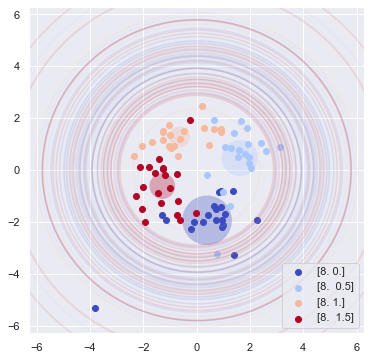

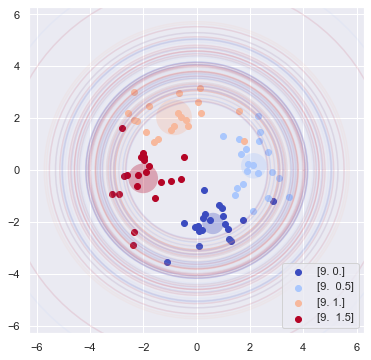

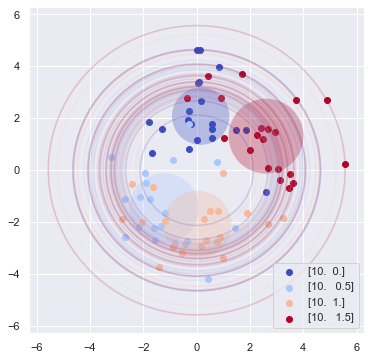

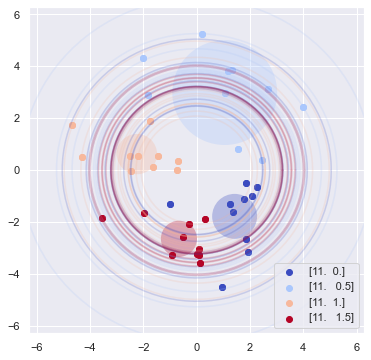

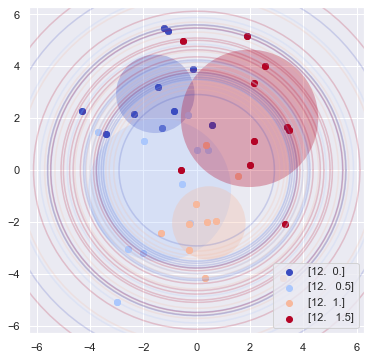

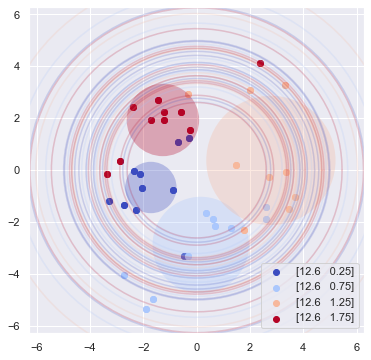

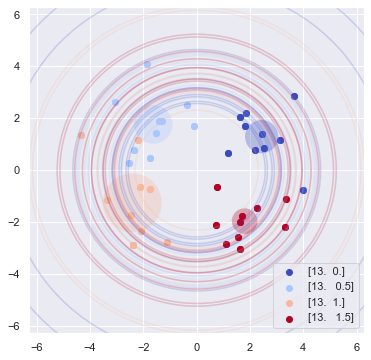

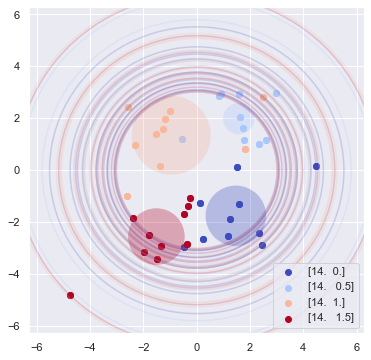

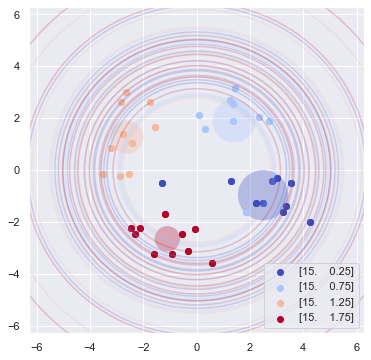

In [54]:
visual_delay = 0.08
visual_delay_samples = int(visual_delay * 300)
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    freqs = np.linspace(0.0, 300 / 2, (1500-visual_delay_samples)//2)
    complex_spectrum = 1/750*fft(eeg[:,:,:,visual_delay_samples:])[:,:,:,:(1500-visual_delay_samples)//2]
    plt.figure(figsize=(6, 6))
    plt.xlim(-2*np.pi, 2*np.pi)
    plt.ylim(-2*np.pi, 2*np.pi)
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,len(classes)))
    for i,c in enumerate(colors):
        for j in range(complex_spectrum.shape[0]):
            max_radius = np.abs(complex_spectrum[j,i,0,:]).max()
            plt.plot(max_radius*np.cos(np.linspace(0, 2*np.pi, 100)),max_radius*np.sin(np.linspace(0, 2*np.pi, 100)),color=c,alpha=0.1)
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()]),label=str(classes[i]),color=c)
        variance_size = np.abs(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].var(axis=0))
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].mean(axis=0)),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].mean(axis=0)),color=c,alpha=0.3,s=(20*variance_size)**2,edgecolor='none')
    ax.legend(loc='lower right')